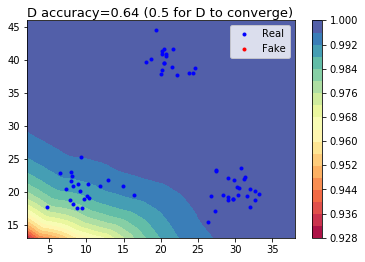

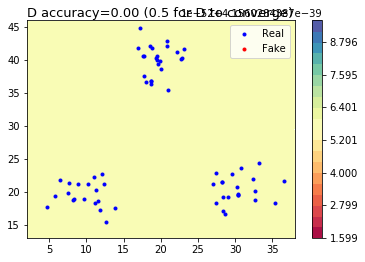

KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# reproducible
torch.manual_seed(2019)
np.random.seed(2019)

# data
data = pd.read_csv('datasets/toy.csv',header=None)
data=data.values

# hyper-parameters
BATCH_SIZE = 64
LR_G = 0.001 # learning rate for generator
LR_D = 0.001 # learning rate for discriminator
random_neuron = 2 # number of neurons as input of generator
components = 2 # total number of points that G generated

def create_G():
    G = nn.Sequential(
    nn.Linear(random_neuron, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, components),
    )
    return G

number_G = 20
G_group = {}
for k in range(number_G):
    G_group['G'+str(k)] = create_G()

# # define G/generator
# G = nn.Sequential(
#     nn.Linear(random_neuron, 128),
#     nn.ReLU(),
#     nn.Linear(128, 128),
#     nn.ReLU(),
#     nn.Linear(128, components),
# )

# define D/discriminator
D = nn.Sequential(
    nn.Linear(components, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)

# optimization
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
# opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)
opt_G_group = {}
for k in range(number_G):
    opt_G_group['G'+str(k)] = torch.optim.Adam(G_group['G'+str(k)].parameters(), lr=LR_G)

plt.ion() 

D_loss_history = []
G_loss_history = []

for step in range(10000):
    

    # random samples of real data
    idx = np.random.choice(len(data), BATCH_SIZE)
    #idx = range(len(data))
    selected_real = data[idx]
    selected_real = torch.from_numpy(selected_real).float()
    
    D_loss_group = {}
    G_loss_group = {}
    D_loss = 0
    G_loss = 0
    for k in range(number_G):
    
        # random noises
        G_noise = torch.randn(BATCH_SIZE, random_neuron)
        G_data = G_group['G'+str(k)](G_noise)

        prob_real = D(selected_real) # D try to increase this prob
        prob_fake = D(G_data) # D try to decrease this prob

        D_loss_group['G'+str(k)] = - torch.mean(torch.log(prob_real) + torch.log(1. - prob_fake))
        G_loss_group['G'+str(k)] = torch.mean(torch.log(1. - prob_fake))
    
        D_loss = D_loss + D_loss_group['G'+str(k)] / number_G
        G_loss = G_loss + G_loss_group['G'+str(k)] / number_G
    
#         D_loss_history.append(D_loss)
#         G_loss_history.append(G_loss)

    for _ in range(3):
        opt_D.zero_grad()
        D_loss.backward(retain_graph=True)    # reusing computational graph
        opt_D.step()
        
    for k in range(number_G):
        opt_G_group['G'+str(k)].zero_grad()
        G_loss_group['G'+str(k)].backward()
        opt_G_group['G'+str(k)].step()

    if step % 500 == 0:
        plt.cla()
        plt.plot(selected_real.data.numpy()[:,0],selected_real.data.numpy()[:,1],'.b', label='Real')
        plt.plot(G_data.data.numpy()[:,0],G_data.data.numpy()[:,1],'.r', label='Fake')
        plt.xlim(round(min(data[:,0])) - 1, round(max(data[:,0])) + 1)
        plt.ylim(round(min(data[:,1])) - 1, round(max(data[:,1])) + 1)

        plt.text(round(min(data[:,0])) - 1, round(max(data[:,1])) + 1.5, 'D accuracy=%.2f (0.5 for D to converge)' % prob_real.data.numpy().mean(), fontdict={'size': 13})
        plt.legend(loc='upper right', fontsize=10);

        # visualize the background
        x = np.arange(round(min(data[:,0])) - 1, round(max(data[:,0])) + 1, 0.1)
        y = np.arange(round(min(data[:,1])) - 1, round(max(data[:,1])) + 1, 0.1)
        xx, yy = np.meshgrid(x, y, sparse=True)

        a = xx + yy - yy
        b = xx + yy - xx
        mem = np.concatenate([a.reshape([a.shape[0],a.shape[1],1]),b.reshape([a.shape[0],a.shape[1],1])],axis=2)

        z = D(torch.from_numpy(mem).float()).data.numpy()
        h = plt.contourf(x,y,z.reshape(z.shape[0],z.shape[1]), 20, cmap='Spectral')
        plt.colorbar();
        plt.show()
        
plt.ioff()
plt.show()


In [ ]:
# visualize the background
x = np.arange(round(min(data[:,0])) - 10, round(max(data[:,0])) + 10, 0.1)
y = np.arange(round(min(data[:,1])) - 10, round(max(data[:,1])) + 10, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)

a = xx + yy - yy
b = xx + yy - xx
mem = np.concatenate([a.reshape([a.shape[0],a.shape[1],1]),b.reshape([a.shape[0],a.shape[1],1])],axis=2)

z = D(torch.from_numpy(mem).float()).data.numpy()
plt.plot(data[:,0],data[:,1],'.b', label='Real')
h = plt.contourf(x,y,z.reshape(z.shape[0],z.shape[1]), 20, cmap='Spectral')
plt.colorbar();
plt.show()

---